In [101]:
import numpy as np
import pandas as pd
import nose.tools as nt
import seaborn as sns
import matplotlib.pyplot as plt

from selectinf.base import (full_targets,
                     selected_targets,
                     debiased_targets)
from selectinf.base import restricted_estimator
import regreg.api as rr
import scipy.stats
from scipy.stats import norm as ndist

from selectinf.randomized.group_lasso_query import (group_lasso,
                                                    split_group_lasso)

# Data Cleaning

In [102]:
data_raw = pd.read_csv("data_groups_dummy_encoded.csv")

In [103]:
data_raw

,SEQN,depressed,RIDAGEYR,INDFMPIR,BMXBMI,DBD895,DBD905,DBD910,RIDRETH1_Mexican_American,RIDRETH1_Other_Hispanic,...,RIAGENDR_man,DMDBORN4_US,ALQ111_dummy,ALQ151_dummy,BPQ020_hypertension,BPQ080_high_cholesterol,SMQ020_smoke,MCQ010_asthma,MCQ053_anemia,MCQ092_blood_transfusion
0,109273,1,36,0.83,21.9,2,0,7,0,0,...,1,1,1,0,0,0,1,0,0,0
1,109274,0,68,1.20,30.2,0,0,0,0,0,...,1,1,1,0,1,1,0,0,0,0
2,109282,0,76,3.61,26.6,1,1,8,0,0,...,1,1,1,0,1,1,1,0,1,0
3,109292,0,58,1.60,30.5,2,10,3,0,1,...,1,1,1,0,1,1,0,1,0,0
4,109293,0,44,0.02,30.1,3,7,0,0,0,...,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5980,124814,0,64,2.00,37.5,3,1,2,0,0,...,1,1,1,0,0,0,1,0,0,0
5981,124815,0,52,5.00,29.5,1,0,0,0,0,...,1,1,1,0,0,0,1,0,0,0
5982,124817,0,67,2.19,37.9,4,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
5983,124818,0,40,3.82,38.2,4,5,0,0,0,...,1,1,1,0,0,0,0,0,0,0


In [104]:
DBQ197 = data_raw[["DBQ197_never","DBQ197_often",
        "DBQ197_rarely", "DBQ197_sometimes"]].to_numpy()

In [105]:
(data_raw["ALQ111_dummy"] != 1).sum()

0

In [106]:
data_X = data_raw[data_raw.columns[2:50]].drop(columns="ALQ111_dummy")

In [107]:
data_X.columns

Index(['RIDAGEYR', 'INDFMPIR', 'BMXBMI', 'DBD895', 'DBD905', 'DBD910',
       'RIDRETH1_Mexican_American', 'RIDRETH1_Other_Hispanic',
       'RIDRETH1_Non_Hispanic_White', 'RIDRETH1_Non_Hispanic_Black',
       'DMDEDUC2_1', 'DMDEDUC2_2', 'DMDEDUC2_3', 'DMDEDUC2_4',
       'DMDMARTZ_married_living_with', 'DMDMARTZ_sep', 'INDFMMPC_1',
       'INDFMMPC_2', 'ALQ121_0', 'ALQ121_1', 'ALQ121_2', 'ALQ121_3',
       'ALQ121_4', 'ALQ121_5', 'ALQ121_6', 'ALQ121_7', 'ALQ121_8', 'ALQ121_9',
       'DBQ700_1', 'DBQ700_2', 'DBQ700_3', 'DBQ700_4', 'DBQ197_never',
       'DBQ197_rarely', 'DBQ197_sometimes', 'DBQ197_often', 'DIQ010_diabetes',
       'DIQ010_diabetes_borderline', 'RIAGENDR_man', 'DMDBORN4_US',
       'ALQ151_dummy', 'BPQ020_hypertension', 'BPQ080_high_cholesterol',
       'SMQ020_smoke', 'MCQ010_asthma', 'MCQ053_anemia',
       'MCQ092_blood_transfusion'],
      dtype='object')

In [108]:
data_X = data_X.to_numpy()

In [109]:
np.linalg.matrix_rank(data_X)

47

In [110]:
data_X.shape

(5985, 47)

In [111]:
design_X = np.zeros((5985,48))
design_X[:,0] = np.ones((5985,))
design_X[:,1:48] = data_X

In [112]:
np.linalg.matrix_rank(design_X)

48

In [113]:
design_X.shape

(5985, 48)

In [114]:
design_X

array([[ 1.  , 36.  ,  0.83, ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 68.  ,  1.2 , ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 76.  ,  3.61, ...,  0.  ,  1.  ,  0.  ],
       ...,
       [ 1.  , 67.  ,  2.19, ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 40.  ,  3.82, ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 63.  ,  3.71, ...,  1.  ,  0.  ,  0.  ]])

# Construct Groups

In [115]:
data_raw[data_raw.columns[2:50]].drop(columns="ALQ111_dummy").columns

Index(['RIDAGEYR', 'INDFMPIR', 'BMXBMI', 'DBD895', 'DBD905', 'DBD910',
       'RIDRETH1_Mexican_American', 'RIDRETH1_Other_Hispanic',
       'RIDRETH1_Non_Hispanic_White', 'RIDRETH1_Non_Hispanic_Black',
       'DMDEDUC2_1', 'DMDEDUC2_2', 'DMDEDUC2_3', 'DMDEDUC2_4',
       'DMDMARTZ_married_living_with', 'DMDMARTZ_sep', 'INDFMMPC_1',
       'INDFMMPC_2', 'ALQ121_0', 'ALQ121_1', 'ALQ121_2', 'ALQ121_3',
       'ALQ121_4', 'ALQ121_5', 'ALQ121_6', 'ALQ121_7', 'ALQ121_8', 'ALQ121_9',
       'DBQ700_1', 'DBQ700_2', 'DBQ700_3', 'DBQ700_4', 'DBQ197_never',
       'DBQ197_rarely', 'DBQ197_sometimes', 'DBQ197_often', 'DIQ010_diabetes',
       'DIQ010_diabetes_borderline', 'RIAGENDR_man', 'DMDBORN4_US',
       'ALQ151_dummy', 'BPQ020_hypertension', 'BPQ080_high_cholesterol',
       'SMQ020_smoke', 'MCQ010_asthma', 'MCQ053_anemia',
       'MCQ092_blood_transfusion'],
      dtype='object')

In [116]:
groups = np.zeros((48,))
groups[0] = int(0) # Intercept
# Singletons
for i in range(1,7):
    groups[i] = int(i)
# RIDRETH1
groups[7:11] = int(7)
# DMDEDUC2
groups[11:15] = int(8)
# DMDMARTZ
groups[15:17] = int(9)
# INDFMMPC
groups[17:19] = int(10)
# ALQ121
groups[19:29] = int(11)
# DBQ700
groups[29:33] = int(12)
# DBQ197
groups[33:37] = int(13)
# DIQ010
groups[37:39] = int(14)
# Singletons
for i in range(39,48):
    groups[i] = int(i-24)

groups = groups.astype(int)

In [117]:
def calc_avg_group_size(groups):
    sizes = []
    for g in range(np.max(groups)+1):
        g_flag = (groups == g)
        sizes.append(g_flag.sum())

    return sizes, np.mean(sizes)

In [118]:
sizes, avg_sizes = calc_avg_group_size(groups)

In [119]:
col_names = data_raw[data_raw.columns[2:50]].drop(columns="ALQ111_dummy").columns.values.tolist()
col_names = ['Intercept'] + col_names

In [120]:
# Sanity check for groupings
pd.DataFrame([groups,col_names])

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0,1,2,3,4,5,6,7,7,7,...,14,15,16,17,18,19,20,21,22,23
1,Intercept,RIDAGEYR,INDFMPIR,BMXBMI,DBD895,DBD905,DBD910,RIDRETH1_Mexican_American,RIDRETH1_Other_Hispanic,RIDRETH1_Non_Hispanic_White,...,DIQ010_diabetes_borderline,RIAGENDR_man,DMDBORN4_US,ALQ151_dummy,BPQ020_hypertension,BPQ080_high_cholesterol,SMQ020_smoke,MCQ010_asthma,MCQ053_anemia,MCQ092_blood_transfusion


In [121]:
n,p = design_X.shape
scaling_cts = np.ones((p,))
scaling_cts[1:7] = design_X.std(0)[1:7]
cts_logical = np.zeros((p,))
cts_logical[1:7] = 1.

In [122]:
print(np.linalg.matrix_rank(design_X))
scaling = design_X.std(0) * np.sqrt(n)
scaling[0] = np.sqrt(n)
scaling[7:p] = np.sqrt(n)

X_standardized = design_X - (cts_logical * design_X.mean(axis = 0))
print(np.linalg.matrix_rank(X_standardized))
X_standardized = X_standardized / scaling[None, :]
print(np.linalg.matrix_rank(X_standardized))

48
48
48


In [123]:
X_standardized[10:18,45:50]

array([[0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.0129, 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ]])

 # Results

In [124]:
np.random.seed(48105)

## Fixing 'weight_frac' = 1

In [125]:
def plot_single_confidence_interval(x, point_est, interval,
                                    color='#2187bb', horizontal_line_width=0.25):

    left = x - horizontal_line_width / 2
    top = interval[0]
    right = x + horizontal_line_width / 2
    bottom = interval[1]
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, point_est, 'o', color='#f44336')

def plot_full_CIs(point_ests, intervals, col_names, nonzero, title):
    plt.figure(figsize=(10,6))
    col_names = np.array(col_names)
    E_card = len(col_names[nonzero])
    selected_col_names = col_names[nonzero]
    plt.xticks(list(range(1, E_card+1)), selected_col_names,
               rotation=360-45, ha='left')
    plt.title(title)
    for j in range(E_card):
        plot_single_confidence_interval(j+1, point_est=point_ests[j],
                                        interval=intervals[j])
    plt.show()


In [126]:
Y = data_raw["depressed"]

In [127]:
def split_inference(X, Y, n, p, groups, group_sizes,
                    weight_frac=1. / np.sqrt(avg_sizes),
                    proportion=0.67):
    # Setup tuning parameters
    sigma_ = np.std(Y)
    weights = dict([(i, weight_frac * np.sqrt(group_sizes[i]) * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])
    weights[0] = 0

    # Solve the split lasso objective
    conv = split_group_lasso.logistic(X=X,
                                      successes=Y,
                                      trials=np.ones(n),
                                      groups=groups,
                                      weights=weights,
                                      useJacobian=True,
                                      proportion=proportion)
    signs, soln = conv.fit()
    nonzero = signs != 0

    conv.setup_inference(dispersion=1)

    target_spec = selected_targets(conv.loglike,
                                   conv.observed_soln,
                                   dispersion=1)

    result = conv.inference(target_spec,
                            method='selective_MLE',
                            level=0.9)
    MLestimates = result['MLE']
    pval = result['pvalue']
    intervals = np.asarray(result[['lower_confidence',
                                   'upper_confidence']])

    return MLestimates, intervals, pval, nonzero

In [128]:
MLestimates, intervals, pval, nonzero = split_inference(X=X_standardized,
                                                        Y=Y, n=n, p=p,
                                                        groups=groups,
                                                        group_sizes=sizes,
                                                        weight_frac=1./np.sqrt(avg_sizes),
                                                        proportion=0.67)

In [129]:
MLestimates

0   -201.512249
1    -34.453590
2     11.627510
3     16.434367
4    -49.116400
5     70.003718
6     32.409886
7     36.977773
Name: MLE, dtype: float64

In [130]:
np.set_printoptions(suppress=True, precision=4)
print(np.array(pval))

[0.     0.     0.0007 0.     0.     0.     0.0002 0.0001]


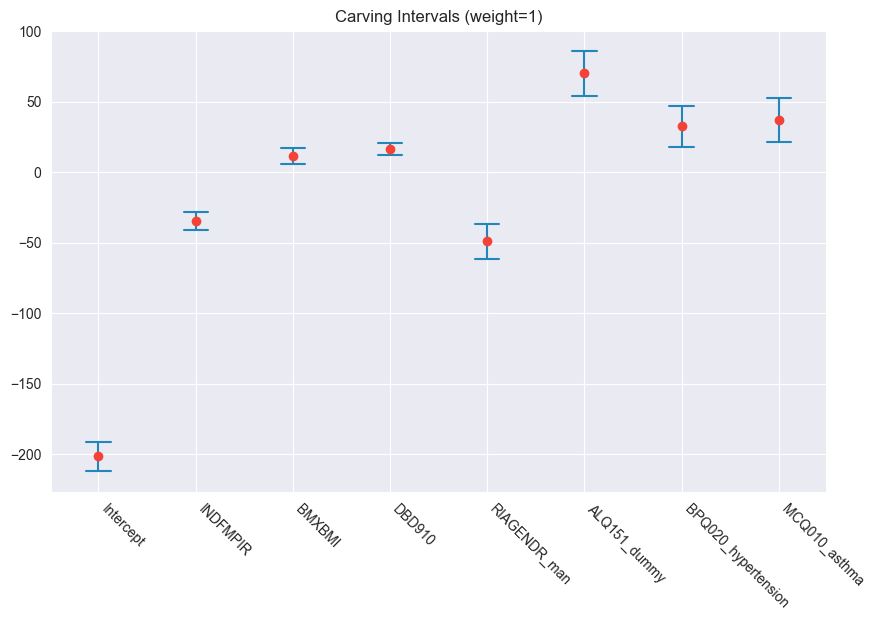

In [131]:
plot_full_CIs(MLestimates, intervals, col_names, nonzero,
              "Carving Intervals (weight=1)")

In [132]:
def randomized_inference(X, Y, n, p, groups, group_sizes,
                         weight_frac=1. / np.sqrt(avg_sizes),
                         proportion=0.67,
                         randomizer_scale=None):
    hess = None
    if randomizer_scale is None:
        # Estimate randomizer covariance if not using isotropic randomization
        def estimate_hess():
            loglike = rr.glm.logistic(X, successes=Y, trials=np.ones(n))
            # For LASSO, this is the OLS solution on X_{E,U}
            beta_full = restricted_estimator(loglike, np.array([True] * p))
            def pi_hess(x):
                return np.exp(x) / (1 + np.exp(x)) ** 2

            # Calculation the asymptotic covariance of the MLE
            W = np.diag(pi_hess(X @ beta_full))

            return X.T @ W @ X * (1 - proportion) / proportion
        hess = estimate_hess()

    # Setup tuning parameters
    sigma_ = np.std(Y)
    weights = dict([(i, weight_frac * np.sqrt(group_sizes[i]) * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])
    weights[0] = 0

    if hess is not None:
        # Estimated randomization covariance
        print("Estimated hessian used.")
        conv = group_lasso.logistic(X=X,
                                successes=Y,
                                trials=np.ones(n),
                                groups=groups,
                                weights=weights,
                                useJacobian=True,
                                cov_rand = hess)
    else:
        # Isotropic
        print("Isotropic randomization used.")
        conv = group_lasso.logistic(X=X,
                                successes=Y,
                                trials=np.ones(n),
                                groups=groups,
                                weights=weights,
                                useJacobian=True,
                                randomizer_scale=randomizer_scale * sigma_)
    signs, soln = conv.fit()
    nonzero = signs != 0

    conv.setup_inference(dispersion=1)

    target_spec = selected_targets(conv.loglike,
                                   conv.observed_soln,
                                   dispersion=1)

    result = conv.inference(target_spec,
                            method='selective_MLE',
                            level=0.9)

    pval = result['pvalue']
    MLestimates = result['MLE']
    intervals = np.asarray(result[['lower_confidence',
                                   'upper_confidence']])


    return MLestimates, intervals, pval, nonzero

In [182]:
MLestimates_r, intervals_r, pval_r, nonzero_r = randomized_inference(X=X_standardized,
                                                                     Y=Y, n=n, p=p,
                                                                     groups=groups,
                                                                     group_sizes=sizes,
                                                                     weight_frac=1. / np.sqrt(avg_sizes),
                                                                     proportion=0.9)

Estimated hessian used.


In [183]:
MLestimates_r

0   -191.100690
1    -22.768551
2     15.736996
3     20.737685
4    -30.937406
5     66.350195
6     21.903317
7     32.018048
Name: MLE, dtype: float64

In [184]:
np.set_printoptions(suppress=True, precision=4)
print(np.array(pval_r))

[0.     0.     0.     0.     0.0001 0.     0.0084 0.1659]


In [185]:
nonzero_r.sum()

8

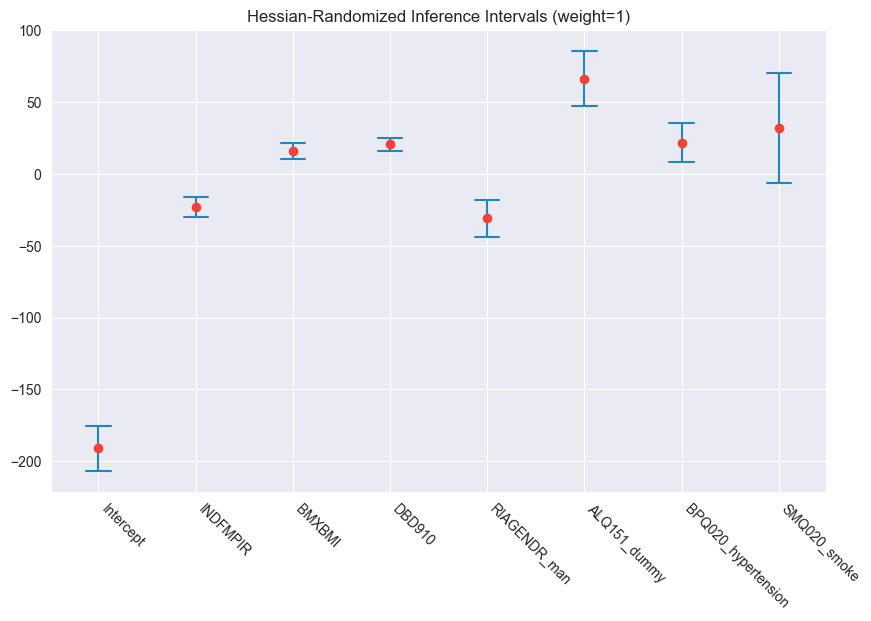

In [186]:
plot_full_CIs(MLestimates_r, intervals_r, col_names, nonzero_r,
              "Hessian-Randomized Inference Intervals (weight=1)")

In [138]:
MLestimates_iso, intervals_iso, pval_iso, nonzero_iso = \
    randomized_inference(X=X_standardized,
                         Y=Y, n=n, p=p,
                         groups=groups,
                         group_sizes=sizes,
                         weight_frac=1/np.sqrt(avg_sizes),
                         randomizer_scale=1)

Isotropic randomization used.


In [139]:
MLestimates_iso

0    -130.638559
1     -29.590488
2       7.079974
3      12.951787
4    -100.609791
5    -102.010970
6     -80.914061
7     -52.032122
8     -52.191226
9      60.044685
10     10.934979
11     20.930991
12     42.371620
Name: MLE, dtype: float64

In [140]:
np.set_printoptions(suppress=True, precision=4)
print(np.array(pval_iso))

[0.     0.     0.0357 0.     0.     0.     0.     0.0002 0.     0.
 0.1417 0.0059 0.    ]


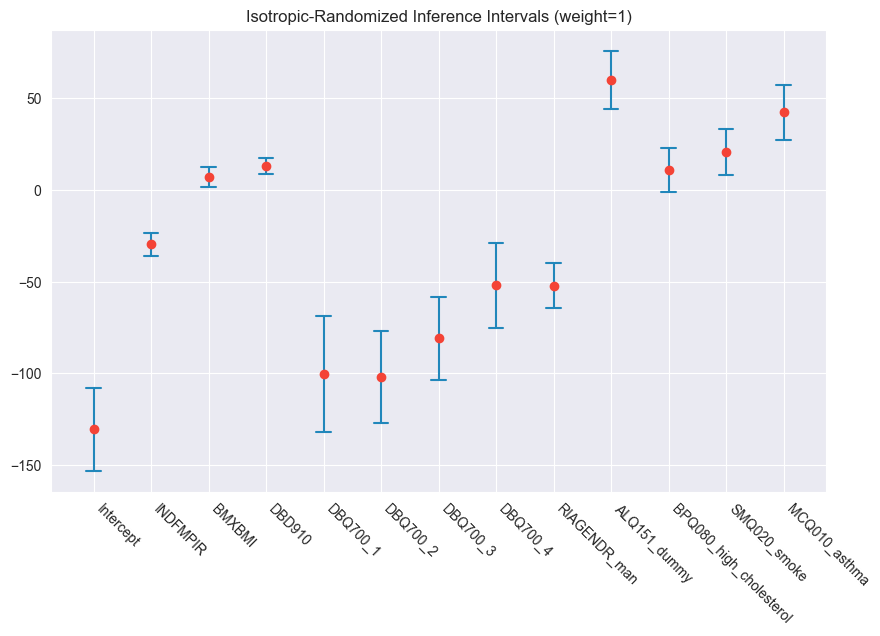

In [141]:
plot_full_CIs(MLestimates_iso, intervals_iso, col_names, nonzero_iso,
              "Isotropic-Randomized Inference Intervals (weight=1)")

In [142]:
def data_splitting(X, Y, n, p, groups, group_sizes, weight_frac=1. / np.sqrt(avg_sizes),
                   proportion=0.67, level=0.9):

    pi_s = proportion
    subset_select = np.zeros(n, np.bool)
    subset_select[:int(pi_s * n)] = True
    n1 = subset_select.sum()
    n2 = n - n1
    np.random.shuffle(subset_select)
    X_S = X[subset_select, :]
    Y_S = Y[subset_select]

    # Selection on the first subset of data
    p = X.shape[1]
    sigma_ = np.std(Y_S)
    # weights = dict([(i, 0.5) for i in np.unique(groups)])
    weights = dict([(i, (n1/n) * weight_frac * np.sqrt(group_sizes[i]) * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])

    conv = group_lasso.logistic(X=X_S,
                                successes=Y_S,
                                trials=np.ones(n1),
                                groups=groups,
                                weights=weights,
                                useJacobian=True,
                                perturb=np.zeros(p),
                                ridge_term=0.)

    signs, _ = conv.fit()
    # print("signs",  signs)
    nonzero = signs != 0

    n1 = subset_select.sum()
    n2 = n - n1

    if nonzero.sum() > 0:
        X_notS = X[~subset_select, :]
        Y_notS = Y[~subset_select]

        # E: nonzero flag

        X_notS_E = X_notS[:, nonzero]

        # Solve for the unpenalized MLE
        def pi_hess(x):
            return np.exp(x) / (1 + np.exp(x)) ** 2

        loglike = rr.glm.logistic(X_notS, successes=Y_notS, trials=np.ones(n2))
        # For LASSO, this is the OLS solution on X_{E,U}
        beta_MLE_notS = restricted_estimator(loglike, nonzero)

        # Calculation the asymptotic covariance of the MLE
        W = np.diag(pi_hess(X_notS_E @ beta_MLE_notS))

        f_info = X_notS_E.T @ W @ X_notS_E
        cov = np.linalg.inv(f_info)

        # Standard errors
        sd = np.sqrt(np.diag(cov))

        # Normal quantiles
        z_low = scipy.stats.norm.ppf((1 - level) / 2)
        z_up = scipy.stats.norm.ppf(1 - (1 - level) / 2)
        assert np.abs(np.abs(z_low) - np.abs(z_up)) < 10e-6

        # Construct confidence intervals
        intervals_low = beta_MLE_notS + z_low * sd
        intervals_up = beta_MLE_notS + z_up * sd
        intervals = np.asarray([intervals_low,intervals_up]).T

        # p-values
        Z_scores = beta_MLE_notS / sd
        cdf_vals = ndist.cdf(Z_scores)
        pvalues = []
        for cdf in cdf_vals:
            pvalues.append(2 * min(cdf, 1 - cdf))

        return beta_MLE_notS, intervals, pvalues, nonzero

    # If no variable selected, no inference
    return None, None, None, None

In [187]:
MLestimates_ds, intervals_ds, pval_ds, nonzero_ds = data_splitting(X=X_standardized,
                                                                     Y=Y, n=n, p=p,
                                                                     groups=groups,
                                                                   group_sizes=sizes,
                                                                   weight_frac=1. / np.sqrt(avg_sizes),
                                                                     proportion=0.9)

/var/folders/6t/y2p8qwk54f7fnkwds613w0040000gs/T/ipykernel_14563/3200997929.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  subset_select = np.zeros(n, np.bool)


In [144]:
MLestimates_ds

array([-176.5584,  -34.4552,   -1.558 ,  -20.2636,   26.702 ,  -50.3874,
          8.2071,  -46.4762,   80.1152])

In [145]:
np.set_printoptions(suppress=True, precision=4)
print(np.array(pval_ds))

[0.     0.0167 0.8998 0.1722 0.0085 0.1175 0.7973 0.0822 0.0058]


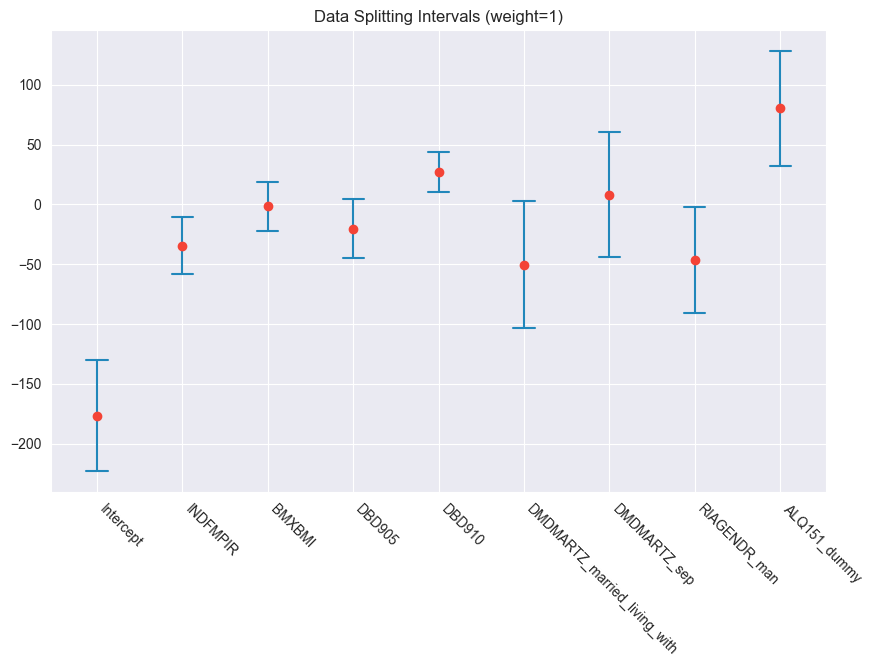

In [146]:
plot_full_CIs(MLestimates_ds, intervals_ds, col_names, nonzero_ds,
              "Data Splitting Intervals (weight=1)")

In [147]:
def naive_inference(X, Y, n, p, groups, group_sizes,
                    weight_frac=1./np.sqrt(avg_sizes),
                    level=0.9):

    # Selection
    p = X.shape[1]
    sigma_ = np.std(Y)
    # weights = dict([(i, 0.5) for i in np.unique(groups)])
    weights = dict([(i, weight_frac * np.sqrt(group_sizes[i]) * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])

    conv = group_lasso.logistic(X=X,
                                successes=Y,
                                trials=np.ones(n),
                                groups=groups,
                                weights=weights,
                                useJacobian=True,
                                perturb=np.zeros(p),
                                ridge_term=0.)

    signs, _ = conv.fit()
    # print("signs",  signs)
    nonzero = signs != 0

    if nonzero.sum() > 0:

        # E: nonzero flag
        X_E = X[:, nonzero]

        # Solve for the unpenalized MLE
        def pi_hess(x):
            return np.exp(x) / (1 + np.exp(x)) ** 2

        loglike = rr.glm.logistic(X, successes=Y, trials=np.ones(n))
        # For LASSO, this is the OLS solution on X_{E,U}
        beta_MLE = restricted_estimator(loglike, nonzero)

        # Calculation the asymptotic covariance of the MLE
        W = np.diag(pi_hess(X_E @ beta_MLE))

        f_info = X_E.T @ W @ X_E
        cov = np.linalg.inv(f_info)

        # Standard errors
        sd = np.sqrt(np.diag(cov))

        # Normal quantiles
        z_low = scipy.stats.norm.ppf((1 - level) / 2)
        z_up = scipy.stats.norm.ppf(1 - (1 - level) / 2)
        assert np.abs(np.abs(z_low) - np.abs(z_up)) < 10e-6

        # Construct confidence intervals
        intervals_low = beta_MLE + z_low * sd
        intervals_up = beta_MLE + z_up * sd
        intervals = np.asarray([intervals_low,intervals_up]).T

        # p-values
        Z_scores = beta_MLE / sd
        cdf_vals = ndist.cdf(Z_scores)
        pvalues = []
        for cdf in cdf_vals:
            pvalues.append(2 * min(cdf, 1 - cdf))

        return beta_MLE, intervals, pvalues, nonzero

    # If no variable selected, no inference
    return None, None, None, None

In [188]:
MLestimates_naive, intervals_naive, pval_naive, nonzero_naive = \
    naive_inference(X=X_standardized, Y=Y, n=n, p=p,
                    groups=groups,group_sizes=sizes,
                    weight_frac=1. / np.sqrt(avg_sizes))

In [189]:
MLestimates_naive

array([-172.5244,  -32.4466,   13.682 ,   14.7719,  -20.9205,    8.1478,
        -49.6876,   71.0628])

In [190]:
np.set_printoptions(suppress=True, precision=4)
print(np.array(pval_naive))

[0.     0.     0.     0.     0.0253 0.4133 0.     0.    ]


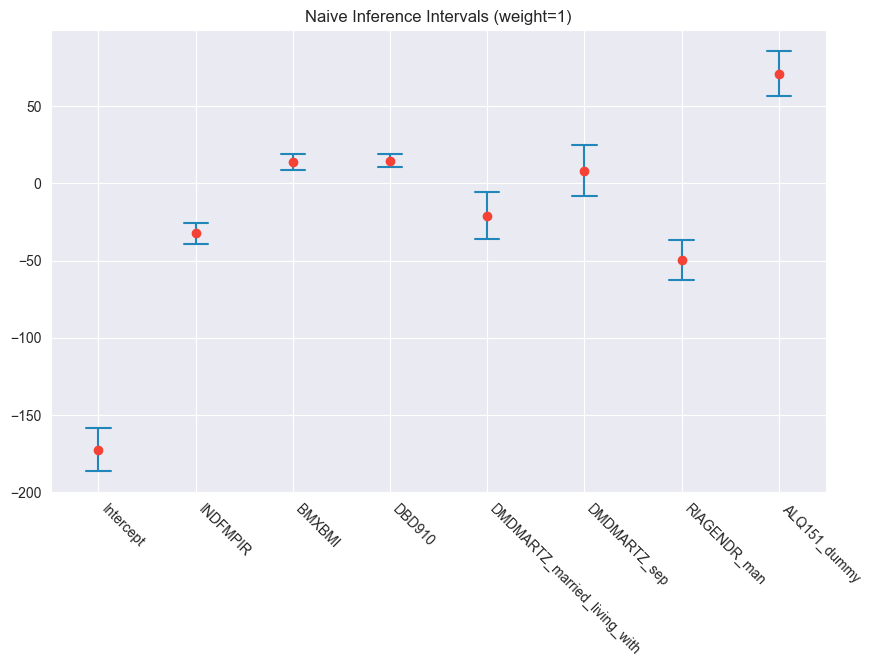

In [191]:
plot_full_CIs(MLestimates_naive, intervals_naive, col_names, nonzero_naive,
              "Naive Inference Intervals (weight=1)")

### Comparing outputs of different methods

In [152]:
def tabulate_results(nonzero_list,intervals_list,groups=groups,colnames=col_names,
                     path=None):
    output_df = pd.DataFrame()
    selected_varnames = []
    for i in set(groups):
        group_i_indices = np.where(groups==i)[0]
        for j in group_i_indices:
            selected = False
            for k in range(len(nonzero_list)):
                if nonzero_list[k][j]:
                    selected = True
            # Include this into the summary if selected
            if selected:
                row = []
                for l in range(len(nonzero_list)):
                    if nonzero_list[l][j]:
                        idx_among_selected = np.sum(nonzero_list[l][0:j])
                        interval_l = intervals_list[l][idx_among_selected,0]
                        interval_u = intervals_list[l][idx_among_selected,1]
                        row.append("(" + str(round(interval_l,3)) + ","
                                   + str(round(interval_u,3)) + ")")
                    else:
                        row.append("-")
                row_df = pd.DataFrame(row).T
                output_df = pd.concat([output_df, row_df], axis=0)
                selected_varnames.append(col_names[j])

    avg_len = []
    for k in range(len(nonzero_list)):
        interval_l = intervals_list[k][:,0]
        interval_u = intervals_list[k][:,1]
        avg_len.append(np.mean(interval_u - interval_l))
    row_df = pd.DataFrame(avg_len).T
    output_df = pd.concat([output_df, row_df], axis=0)
    selected_varnames.append("Avg. CI Length")

    output_df.index = selected_varnames
    if path is not None:
        output_df.to_csv(path)

    return output_df


In [155]:
def tabulate_results(nonzero_list,intervals_list,groups=groups,colnames=col_names,
                     path=None):
    output_df = pd.DataFrame()
    selected_varnames = []
    for i in set(groups):
        group_i_indices = np.where(groups==i)[0]
        for j in group_i_indices:
            selected = False
            for k in range(len(nonzero_list)):
                if nonzero_list[k][j]:
                    selected = True
            # Include this into the summary if selected
            if selected:
                row = []
                for l in range(len(nonzero_list)):
                    if nonzero_list[l][j]:
                        idx_among_selected = np.sum(nonzero_list[l][0:j])
                        interval_l = intervals_list[l][idx_among_selected,0]
                        interval_u = intervals_list[l][idx_among_selected,1]
                        row.append("(" + str(round(interval_l,3)) + ","
                                   + str(round(interval_u,3)) + ")")
                    else:
                        row.append("-")
                row_df = pd.DataFrame(row).T
                output_df = pd.concat([output_df, row_df], axis=0)
                selected_varnames.append(col_names[j])

    avg_len = []
    for k in range(len(nonzero_list)):
        interval_l = intervals_list[k][:,0]
        interval_u = intervals_list[k][:,1]
        avg_len.append(np.mean(interval_u - interval_l))
    row_df = pd.DataFrame(avg_len).T
    output_df = pd.concat([output_df, row_df], axis=0)
    selected_varnames.append("Avg. CI Length")

    output_df.index = selected_varnames
    if path is not None:
        output_df.to_csv(path)

    return output_df

In [192]:
nonzero_list = [nonzero_naive, nonzero_ds, nonzero_r]
intervals_list = [intervals_naive, intervals_ds, intervals_r]
output_comparison = tabulate_results(nonzero_list=nonzero_list,
                                     intervals_list=intervals_list)

In [193]:
output_comparison.columns = ["Naive", "Data splitting", "Hessian Randomized"]

In [194]:
output_comparison.to_csv("weight1.csv")

## Results with other values of 'weight_frac'

### weight_frac = 0.5

In [195]:
MLestimates, intervals, pval, nonzero = split_inference(X=X_standardized,
                                                        Y=Y, n=n, p=p,
                                                        groups=groups,
                                                        group_sizes=sizes,
                                                        weight_frac=0.5/np.sqrt(avg_sizes),
                                                        proportion=0.9)

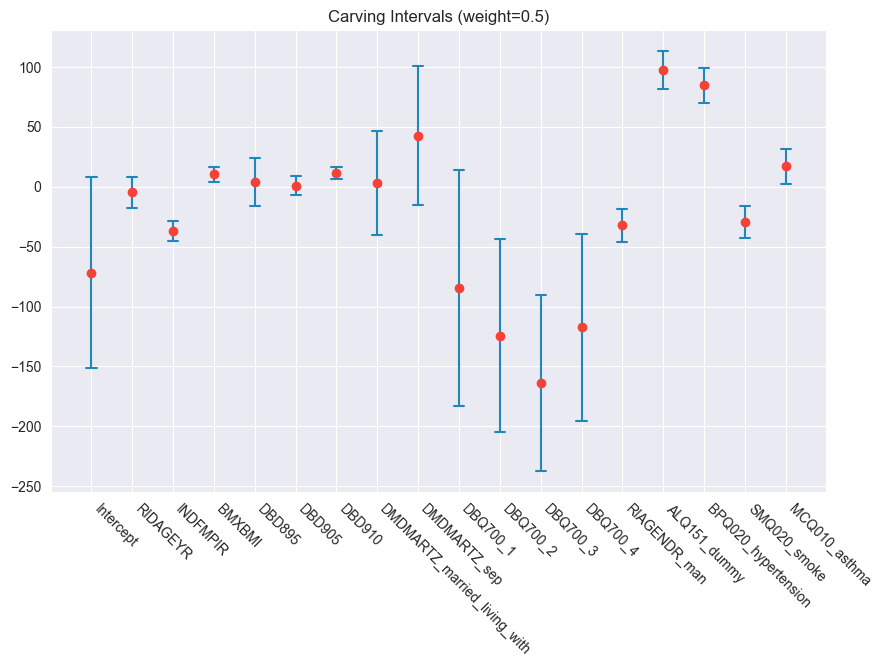

In [196]:
plot_full_CIs(MLestimates, intervals, col_names, nonzero,
              "Carving Intervals (weight=0.5)")

In [197]:
MLestimates_r, intervals_r, pval_r, nonzero_r = randomized_inference(X=X_standardized,
                                                                     Y=Y, n=n, p=p,
                                                                     groups=groups,
                                                                     group_sizes=sizes,
                                                                     weight_frac=0.5 / np.sqrt(avg_sizes),
                                                                     proportion=0.9)

Estimated hessian used.


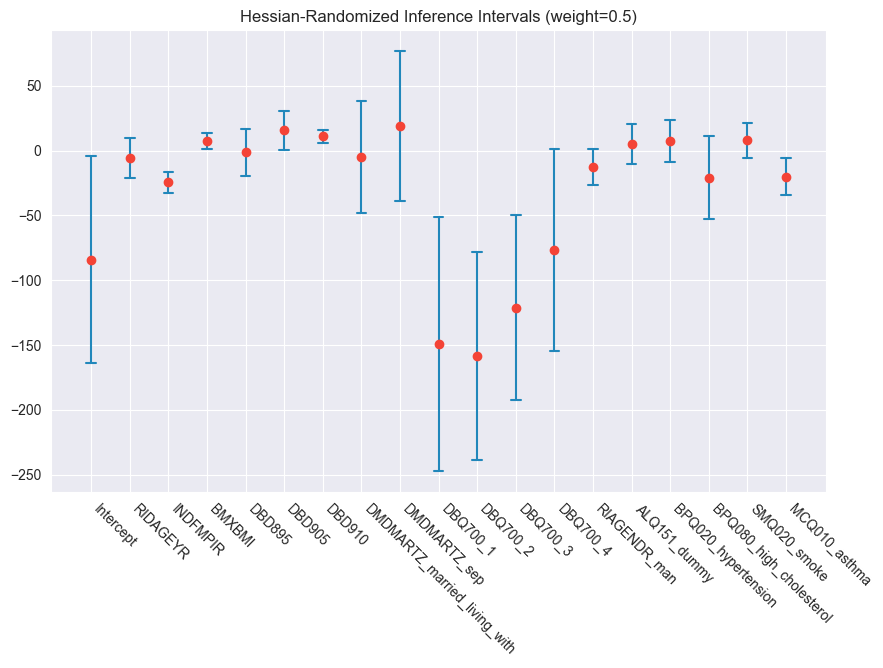

In [198]:
plot_full_CIs(MLestimates_r, intervals_r, col_names, nonzero_r,
              "Hessian-Randomized Inference Intervals (weight=0.5)")

In [199]:
MLestimates_iso, intervals_iso, pval_iso, nonzero_iso = \
    randomized_inference(X=X_standardized,
                         Y=Y, n=n, p=p,
                         groups=groups,
                         group_sizes=sizes,
                         weight_frac=1. / np.sqrt(avg_sizes),
                         randomizer_scale=1)

Isotropic randomization used.


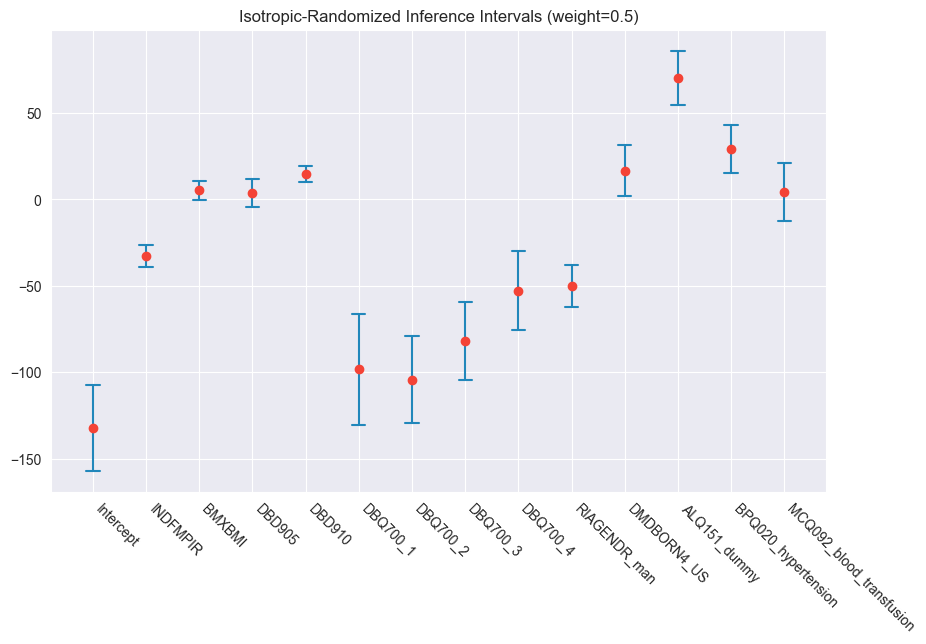

In [200]:
plot_full_CIs(MLestimates_iso, intervals_iso, col_names, nonzero_iso,
              "Isotropic-Randomized Inference Intervals (weight=0.5)")

In [201]:
MLestimates_ds, intervals_ds, pval_ds, nonzero_ds = data_splitting(X=X_standardized,
                                                                     Y=Y, n=n, p=p,
                                                                     groups=groups,
                                                                   group_sizes=sizes,
                                                                   weight_frac=0.5 / np.sqrt(avg_sizes),
                                                                     proportion=0.9)

/var/folders/6t/y2p8qwk54f7fnkwds613w0040000gs/T/ipykernel_14563/3200997929.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  subset_select = np.zeros(n, np.bool)


In [202]:
MLestimates_naive, intervals_naive, pval_naive, nonzero_naive = \
    naive_inference(X=X_standardized, Y=Y, n=n, p=p,
                    groups=groups, group_sizes=sizes, weight_frac=0.5 / np.sqrt(avg_sizes))

In [203]:
nonzero_list = [nonzero_naive, nonzero_ds, nonzero_r]
intervals_list = [intervals_naive, intervals_ds, intervals_r]
output_comparison = tabulate_results(nonzero_list=nonzero_list,
                                     intervals_list=intervals_list)

In [204]:
output_comparison.columns = ["Naive", "Data splitting", "Hessian Randomized"]

In [205]:
output_comparison.to_csv("weight0.5.csv")

### weight_frac = 1.5

In [206]:
MLestimates, intervals, pval, nonzero = split_inference(X=X_standardized,
                                                        Y=Y, n=n, p=p,
                                                        groups=groups,
                                                        group_sizes=sizes,
                                                        weight_frac=1.5 / np.sqrt(avg_sizes),
                                                        proportion=0.9)

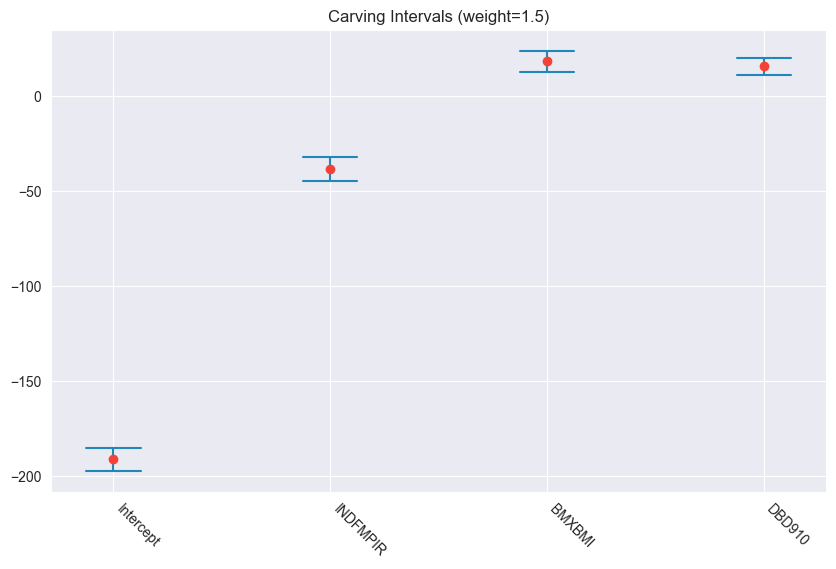

In [207]:
plot_full_CIs(MLestimates, intervals, col_names, nonzero,
              "Carving Intervals (weight=1.5)")

In [208]:
MLestimates_r, intervals_r, pval_r, nonzero_r = randomized_inference(X=X_standardized,
                                                                     Y=Y, n=n, p=p,
                                                                     groups=groups,group_sizes=sizes,
                                                                     weight_frac=1.5 / np.sqrt(avg_sizes),
                                                                     proportion=0.9)

Estimated hessian used.


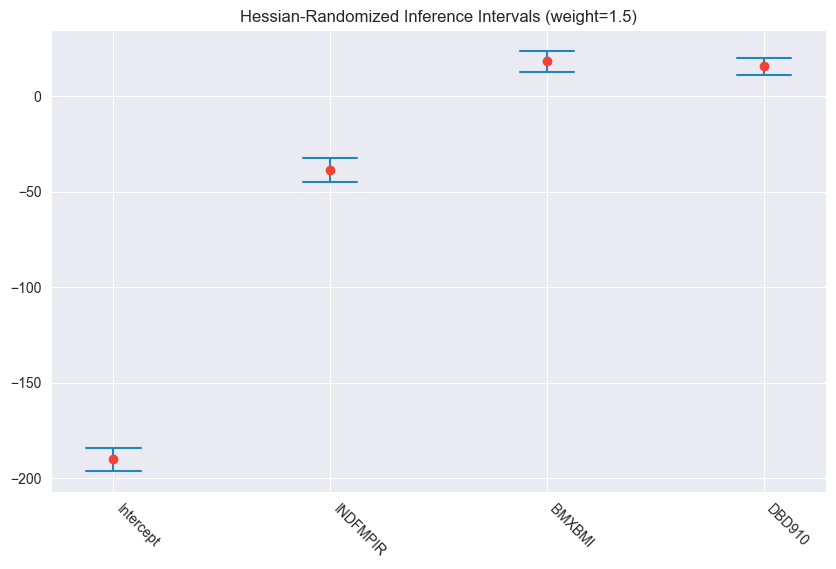

In [209]:
plot_full_CIs(MLestimates_r, intervals_r, col_names, nonzero_r,
              "Hessian-Randomized Inference Intervals (weight=1.5)")

In [210]:
MLestimates_iso, intervals_iso, pval_iso, nonzero_iso = \
    randomized_inference(X=X_standardized,
                         Y=Y, n=n, p=p,
                         groups=groups,
                         group_sizes=sizes,
                         weight_frac=1.5 / np.sqrt(avg_sizes),
                         randomizer_scale=1)

Isotropic randomization used.


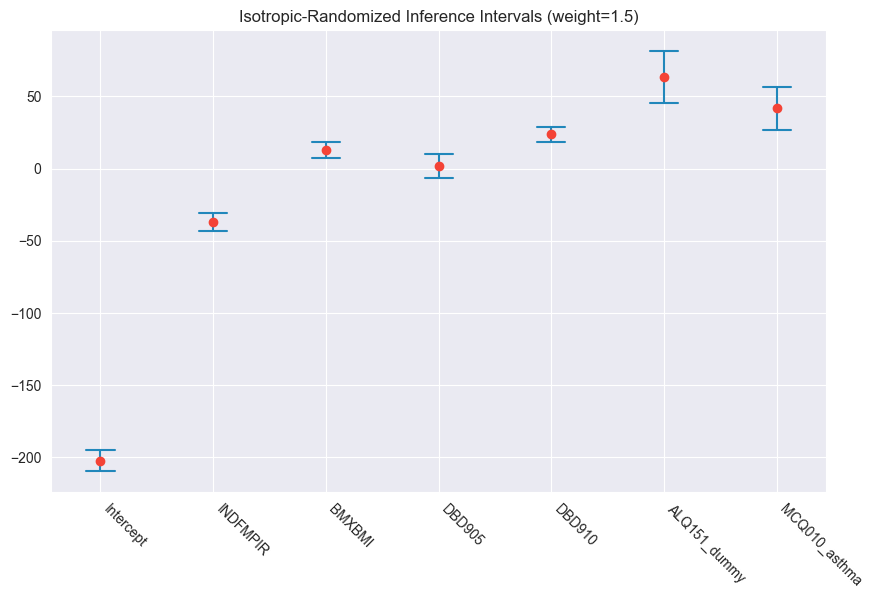

In [211]:
plot_full_CIs(MLestimates_iso, intervals_iso, col_names, nonzero_iso,
              "Isotropic-Randomized Inference Intervals (weight=1.5)")

In [212]:
MLestimates_ds, intervals_ds, pval_ds, nonzero_ds = data_splitting(X=X_standardized,
                                                                     Y=Y, n=n, p=p,
                                                                     groups=groups,group_sizes=sizes,
                                                                   weight_frac=1.5 / np.sqrt(avg_sizes),
                                                                     proportion=0.9)

/var/folders/6t/y2p8qwk54f7fnkwds613w0040000gs/T/ipykernel_14563/3200997929.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  subset_select = np.zeros(n, np.bool)


In [213]:
MLestimates_naive, intervals_naive, pval_naive, nonzero_naive = \
    naive_inference(X=X_standardized, Y=Y, n=n, p=p,
                    groups=groups, group_sizes=sizes, weight_frac=1.5 / np.sqrt(avg_sizes))

In [214]:
nonzero_list = [nonzero_naive, nonzero_ds, nonzero_r]
intervals_list = [intervals_naive, intervals_ds, intervals_r]
output_comparison = tabulate_results(nonzero_list=nonzero_list,
                                     intervals_list=intervals_list)

In [215]:
output_comparison.columns = ["Naive", "Data splitting", "Hessian Randomized"]

In [216]:
output_comparison.to_csv("weight1.5.csv")